In [ ]:
# Aligns a score volume with an annotation volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

from collections import defaultdict

In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [4]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [5]:
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))
# atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
# print atlas_xdim, atlas_ydim, atlas_zdim

def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t))

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
# atlas_cx, atlas_cy, atlas_cz = atlas_centroid

# print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax
print atlas_centroid

[ 404.5  202.   266.5]


load atlas: 1.208918 seconds


In [6]:
stack = 'MD594'

atlasAlignParams_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'

with open(atlasAlignParams_dir + '/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
    
T_final = np.array(map(float, lines[1].strip().split()))

In [11]:
stack = 'MD594'

downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [12]:
# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
# for stack in ['MD594']:

    ################# LOAD TEST VOLUME ######################

section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

93 364


In [34]:
global volume2_allLabels
# volume2_allLabels = []
volume2_allLabels = np.empty((n_labels-1, volume_ymax-volume_ymin+1, volume_xmax-volume_xmin+1, volume_zmax-volume_zmin+1), 
         dtype=np.float16) # use float32 is faster than float16 (2.5s/landmark), maybe because bp files are stored using float32

for l in range(1, n_labels):

    t = time.time()

    volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_%(label)s.bp' % \
                                                  {'stack': stack, 'label': labels[l]}))

    volume2_cropped = volume2[volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1]
    # copy is important, because then you can delete the large array

    volume2_allLabels[l-1] = volume2_cropped.copy()
    
#     volume2_allLabels.append(volume2_cropped.copy())

    del volume2, volume2_cropped
    
    sys.stderr.write('load scoremap %s: %f seconds\n' % (labels[l], time.time() - t)) # ~2.5s

test_ydim, test_xdim, test_zdim = volume2_allLabels[0].shape
test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
test_cx, test_cy, test_cz = test_centroid

print test_xdim, test_ydim, test_zdim
print test_centroid

load scoremap 5N: 2.432718 seconds
load scoremap 7n: 2.202251 seconds
load scoremap 7N: 2.325292 seconds
load scoremap 12N: 2.132456 seconds
load scoremap Pn: 2.485293 seconds
load scoremap VLL: 2.613593 seconds
load scoremap 6N: 2.256216 seconds
load scoremap Amb: 2.151343 seconds
load scoremap R: 2.444256 seconds
load scoremap Tz: 2.262981 seconds
load scoremap RtTg: 2.562091 seconds
load scoremap LRt: 2.173490 seconds
load scoremap LC: 2.198770 seconds
load scoremap AP: 2.168032 seconds


833 473 443
(416.5, 236.5, 236.5)


load scoremap sp5: 2.288226 seconds


In [14]:
dSdxyz = np.empty((n_labels-1, 3) + volume2_allLabels[0].shape, dtype=np.float16) 

# if memory is not limited, using float32 is faster, because the output of np.gradient is of type float32
# time for storing output: float16 4s (due to dtype conversion overhead), float32 1s

# using float16 avoids memory issues that make gradient computation utterly slow, 30s vs. 4s

################# COMPUTE GRADIENTS ######################

# dSdxyz = {}
# DO NOT use python list because python will use contiguous memory for it
# http://stackoverflow.com/questions/12274060/does-python-use-linked-lists-for-lists-why-is-inserting-slow  

t1 = time.time()

for l in range(1, n_labels):

    t = time.time()
    
    gy, gx, gz = np.gradient(volume2_allLabels[l-1], 3, 3, 3) # 3.3 second, much faster than loading
    # if memory is limited, this will be very slow
    
    sys.stderr.write('gradient %s: %f seconds\n' % (labels[l], time.time() - t))
    
    t = time.time()
    
    dSdxyz[l-1, 0] = gx
    dSdxyz[l-1, 1] = gy
    dSdxyz[l-1, 2] = gz
    
#     dSdxyz[labels[l]] = np.array([gx, gy, gz]) # use np.array is better; using python list also causes contiguous memory overhead
    
#     del gx, gy, gz # does not make a difference
    
    sys.stderr.write('store %s: %f seconds\n' % (labels[l], time.time() - t))
    
sys.stderr.write('overall: %f seconds\n' % (time.time() - t1))

gradient 5N: 29.020862 seconds
store 5N: 4.586939 seconds
gradient 7n: 28.543159 seconds
store 7n: 4.328549 seconds
gradient 7N: 28.822023 seconds
store 7N: 4.589520 seconds
gradient 12N: 29.126228 seconds
store 12N: 4.356800 seconds
gradient Pn: 29.150768 seconds
store Pn: 4.406825 seconds
gradient VLL: 29.283031 seconds
store VLL: 4.850501 seconds
gradient 6N: 28.860886 seconds
store 6N: 4.387086 seconds
gradient Amb: 28.898175 seconds
store Amb: 4.377250 seconds
gradient R: 29.120409 seconds
store R: 4.683087 seconds
gradient Tz: 29.040263 seconds
store Tz: 4.404237 seconds
gradient RtTg: 29.571154 seconds
store RtTg: 4.805895 seconds
gradient LRt: 29.404979 seconds
store LRt: 4.572553 seconds
gradient LC: 29.232533 seconds
store LC: 4.772266 seconds
gradient AP: 29.068255 seconds
store AP: 4.461664 seconds
gradient sp5: 29.249990 seconds
store sp5: 4.502889 seconds
overall: 504.492300 seconds


In [19]:
# memory size for gradients
print dSdxyz.size * dSdxyz.dtype.itemsize / 1024**3, 'GB'

14 GB


In [199]:
Tm0 = T_final.reshape((3,4))

tx0, ty0, tz0 = Tm0[:, 3]
A0 = Tm0[:, :3]

atlas_nzs2 = [(np.dot(A0, nzs - atlas_centroid[:,None]) + \
                            np.asarray([tx0 + test_cx, 
                                        ty0 + test_cy, 
                                        tz0 + test_cz])[:,np.newaxis]).astype(np.int16) for nzs in atlas_nzs]

atlas_centroid2 = atlas_nzs2[labels_index['12N']-1].T.mean(axis=0)
print atlas_centroid2

[ 620.59515841  214.79135482  235.31177655]


In [200]:
test_cx2, test_cy2, test_cz2 = atlas_centroid2
test_centroid2 = atlas_centroid2.copy()

pts2_centered = [atlas_nzs2[l-1].T - atlas_centroid2 for l in range(1, n_labels)]    

In [191]:
pp = pts2_centered[labels_index['Pn']-1]
pts2_centered[labels_index['Pn']-1] = pp[pp[:, 2] < 0]

In [201]:
def transform_points(T, pts=None, c=None, pts_centered=None, c_prime=0):
    '''
    T: 1x12 vector
    c: center of volume 1
    c_prime: center of volume 2
    pts: nx3
    '''
    
    if pts_centered is None:
        pts_centered = pts - c
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    A = Tm[:, :3]
        
    pts_prime = np.dot(A, pts_centered.T) + (t + c_prime)[:,None]
        
    return pts_prime.T

def matrix_exp(w):
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    
    theta = np.sqrt(np.sum(w**2))
    
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/theta**2*np.dot(w_skew, w_skew)
    return exp_w

def matrix_exp_v(v):
    t = v[:3]
    w = v[3:]
    
    theta = np.sqrt(np.sum(w**2))
    
    wx, wy, wz = w
    w_skew = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    exp_w = np.eye(3) + np.sin(theta)/theta*w_skew + (1-np.cos(theta))/(theta**2)*np.dot(w_skew, w_skew)
    
    V = np.eye(3) + (1-np.cos(theta))/(theta**2)*w_skew + (theta-np.sin(theta))/(theta**3)*np.dot(w_skew, w_skew)
    
    return exp_w, np.dot(V, t)

In [202]:
def step(T, l, lr, verbose=False, num_samples=1000):
    '''
    T: 1x12 vector
    l: landmark class label
    '''
    
    pts_prime = transform_points(T, pts_centered=pts2_centered[l-1], c_prime=test_centroid2)
    
    xs_prime = pts_prime[:,0]
    ys_prime = pts_prime[:,1]
    zs_prime = pts_prime[:,2]
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
    
    if verbose:
        print 'nz', np.count_nonzero(valid) 
        
    assert np.count_nonzero(valid) > 0, 'No valid pixel after transform'
    
    xs_prime_valid = xs_prime[valid].astype(np.int16)
    ys_prime_valid = ys_prime[valid].astype(np.int16)
    zs_prime_valid = zs_prime[valid].astype(np.int16)
    
    voxel_probs_valid = volume2_allLabels[l-1, ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e6
    score = voxel_probs_valid.sum()
    
    if num_samples is not None:
        # sample some voxels # this seems to make optimization more stable than using all voxels
    
        ii = np.random.choice(range(np.count_nonzero(valid)), num_samples, replace=False)

        dSdx = dSdxyz[l-1, 0, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        dSdy = dSdxyz[l-1, 1, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]
        dSdz = dSdxyz[l-1, 2, ys_prime_valid, xs_prime_valid, zs_prime_valid][ii]

        xss = xs_prime[valid].astype(np.float)[ii]
        yss = ys_prime[valid].astype(np.float)[ii]
        zss = zs_prime[valid].astype(np.float)[ii]
    else:
        # use all voxels    
        dSdx = dSdxyz[l-1, 0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdy = dSdxyz[l-1, 1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        dSdz = dSdxyz[l-1, 2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        xss = xs_prime[valid].astype(np.float)
        yss = ys_prime[valid].astype(np.float)
        zss = zs_prime[valid].astype(np.float)

    #############################################
    
    dMdv = np.c_[dSdx, dSdy, dSdz, 
                 -dSdy*zss + dSdz*yss, 
                 dSdx*zss - dSdz*xss,
                 -dSdx*yss + dSdy*xss].sum(axis=0)

    if verbose:
        print 'dMdv:', dMdv
        print 'score:', score

#     lr = np.array([0, 0, 0, 0, 0, 1e-2])
    global dMdv_historical
    dMdv_historical += dMdv**2
    dMdv_adjusted = dMdv / (1e-10 + np.sqrt(dMdv_historical))
    v_opt = lr * dMdv_adjusted # no minus sign because maximizing

#     global iteration
#     lr = np.array([0, 0, 0, 0, 0, 1e-7])
#     v_opt = lr * np.exp(-iteration/1000.) * dMdv # no minus sign because maximizing
#     v_opt = lr * dMdv # no minus sign because maximizing

    if verbose:
        print 'v_opt:', v_opt

    theta = np.sqrt(np.sum(v_opt[3:]**2))
    if verbose:
        print 'theta:', theta
    assert theta < np.pi
        
    exp_w, Vt = matrix_exp_v(v_opt)
    
    if verbose:
        print 'Vt:' , Vt
    
    Tm = np.reshape(T, (3,4))
    t = Tm[:, 3]
    R = Tm[:, :3]
                        
    R_new = np.dot(exp_w, R)
    t_new = np.dot(exp_w, t) + Vt
    
    if verbose:
        print '\n'

    return np.column_stack([R_new, t_new]).flatten(), score

0.182524
[[ 0.99129612 -0.12031597 -0.05344225  0.937444  ]
 [ 0.11689749  0.9911401  -0.06305781  3.03668255]
 [ 0.06055562  0.0562617   0.99657796  8.06181255]]
0.152403
0.182408


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in absolute


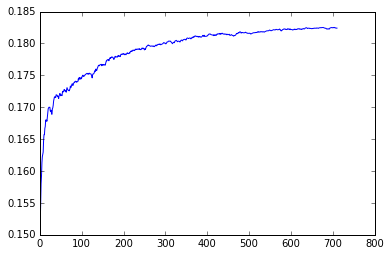

In [203]:
T = [1,0,0,0,0,1,0,0,0,0,1,0]

dMdv_historical = np.zeros((6,))

score_best = 0
scores = []

for iteration in range(5000):
#     T, s = step(T, labels_index['AP'], lr=np.array([0,0,0,0,0,1e-2]))
#     T, s = step(T, labels_index['7N'], lr=np.array([1,1,1,1e-1,1e-1,1e-1]), verbose=False)
    T, s = step(T, labels_index['12N'], lr=np.array([1,1,1,1e-2,1e-2,1e-2]), verbose=False)
    
    scores.append(s)
    
    history_len = 50
    if iteration > 10:
        if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                  np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-4:
            break

    if s > score_best:
        best_gradient_descent_params = T
        score_best = s
    
print score_best
print best_gradient_descent_params.reshape((3,4))

print scores[0]
print scores[-1]

plt.plot(scores);

In [ ]:
del dSdxyz

In [204]:
print np.linalg.det(T_final.reshape((3,4))[:3,:3])
print T_final.reshape((3,4))

print np.linalg.det(best_gradient_descent_params.reshape((3,4))[:3,:3])
print best_gradient_descent_params.reshape((3,4))

0.877898376041
[[  9.89607000e-01   2.40036000e-01  -1.37680000e-02   6.78861730e+01]
 [ -2.24423000e-01   8.70130000e-01   6.98430000e-02  -3.74003500e+00]
 [  5.93540000e-02  -7.81530000e-02   9.51993000e-01  -2.57590500e+00]]
1.0
[[ 0.99129612 -0.12031597 -0.05344225  0.937444  ]
 [ 0.11689749  0.9911401  -0.06305781  3.03668255]
 [ 0.06055562  0.0562617   0.99657796  8.06181255]]


In [205]:
################# PROJECT ATLAS TO IMAGE ######################

T2 = np.reshape(best_gradient_descent_params, (3,4))
tx_best, ty_best, tz_best  = T2[:, 3]
Amat_best = T2[:, :3]

# atlas_nzs_projected_to_test = [(np.dot(A0, vs - atlas_centroid[:, np.newaxis]) + \
#                                             np.asarray([tx0 + test_cx, 
#                                                         ty0 + test_cy, 
#                                                         tz0 + test_cz])[:,np.newaxis]).astype(np.int)
#                                 for vs in atlas_nzs]

atlas_nzs_projected_to_test = [(np.dot(Amat_best, vs - atlas_centroid2[:, np.newaxis]) + \
                                            np.asarray([tx_best + test_cx2, 
                                                        ty_best + test_cy2, 
                                                        tz_best + test_cz2])[:,np.newaxis]).astype(np.int16)
                                for vs in atlas_nzs2]

# print np.min(atlas_nzs_projected_to_test[0], axis=1)
# print np.max(atlas_nzs_projected_to_test[0], axis=1)

test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)

for l in range(1, n_labels):

    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int16)

    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
            (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

    atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]

    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    volume1[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]


# del atlas_nzs_projected_to_test

# bp.pack_ndarray_file(test_volume_atlas_projected, 
#                      volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

# with open(os.path.join(atlasAlignParams_dir, '%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:
#     f.writelines(' '.join(['%f']*len(params_best_upToNow)) % tuple(params_best_upToNow) + '\n')
#     f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
#     f.writelines(' '.join(['%f']*len(lr)) % tuple(lr) + '\n')
#     f.writelines('%d' % iteration + '\n')

# annotationsViz_dir = create_if_not_exists(annotationsViz_rootdir + '/' + stack)

In [206]:
dm = DataManager(stack=stack)

190


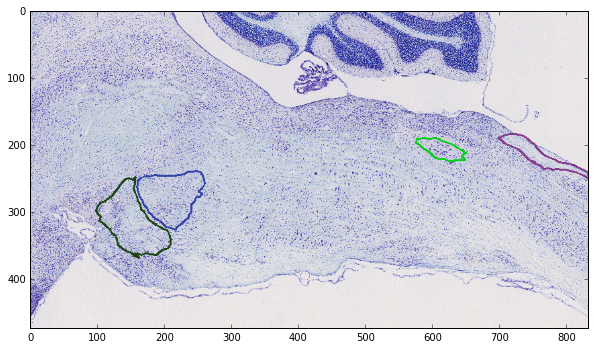

200


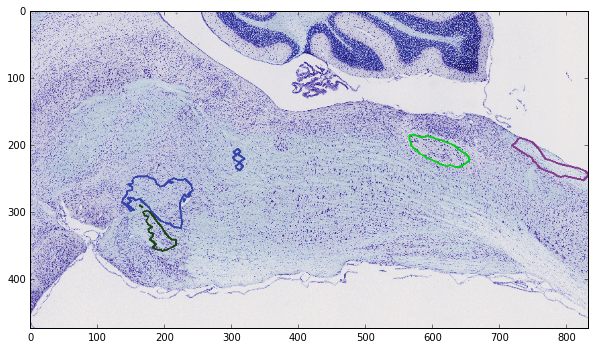

210


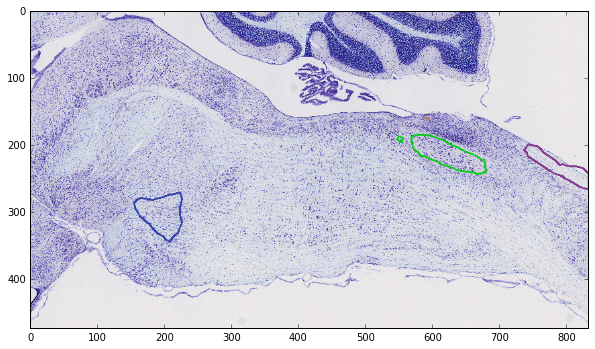

220


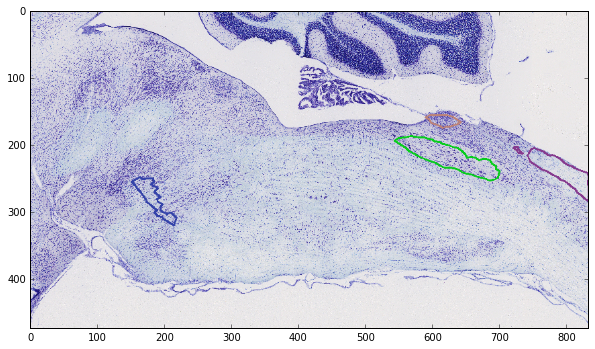

230


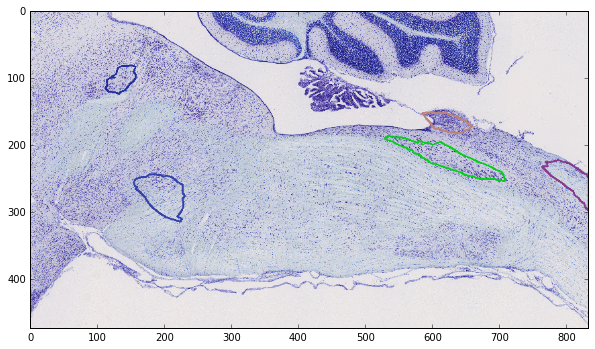

240


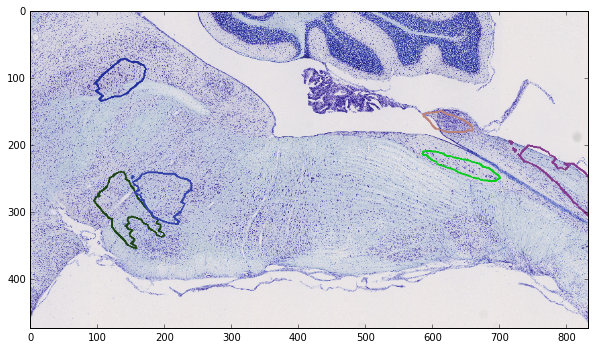

250


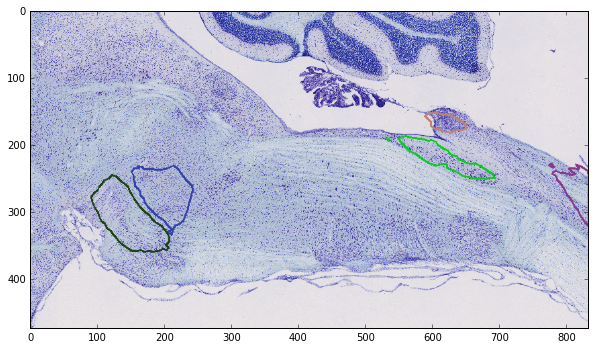

260


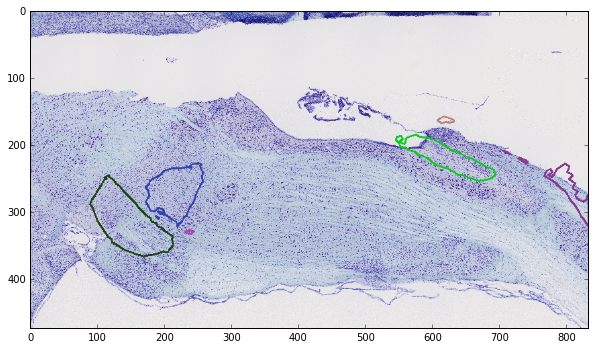

270


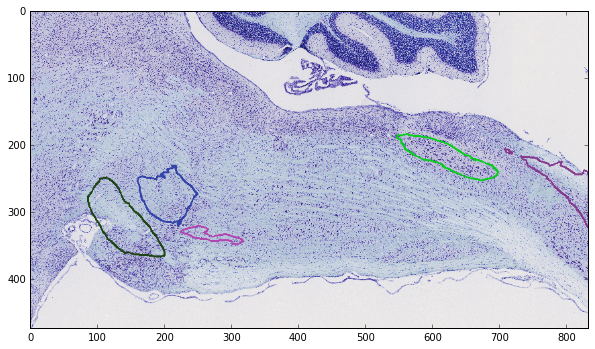

280


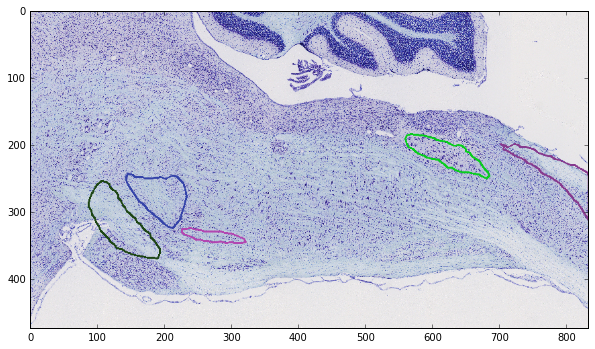

In [208]:
# for z in range(0, test_zdim, 10):
# for z in range(220, 270, 10):
# z = 240

# for z in range(280, 350, 10): # Pn
# for z in range(340, 440, 10): # 7N
# for z in range(30, 150, 10): # 7N
# for z in range(70, 210, 10): # Pn
for z in range(190, 290, 10): # 12N

    print z

    dm.set_slice(map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
                                                                     volume_xmin:volume_xmax+1].copy()

    projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

    for label_ind, cnts in projected_cnts.iteritems():
        for cnt in cnts:
            cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

    plt.figure(figsize=(10, 10));
    plt.imshow(viz)
    plt.show()

    #     cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
    #                 {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
    #                 img_as_ubyte(viz[..., [2,1,0]]))

    #     del viz


    # del test_volume_atlas_projected

    # logger.removeHandler(handler)